<a href="https://colab.research.google.com/github/OlyKoek/Udemy-AIperfectMaster-colabo/blob/main/Section13/make_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モデルの訓練と保存
Google Colaboratoryで画像識別用のモデルを構築し、訓練します。  
今回は、cifar-10を訓練データに使います。  
訓練済みのモデルは保存し、ダウンロードします。

## バージョンの確認
念のために、以下のコードによりtensorflowとKerasのバージョンを確認しておきましょう。

In [2]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.19.0
3.10.0


## 使用ライブラリ

In [15]:
# 必要ライブラリ
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10 # 10 category dataset
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam

from keras.models import Model
from keras.callbacks import LambdaCallback

## 訓練データの読み込み
前のImageDataGeneratorが廃止になっていたので、tensorflow.keras.preprocessing.image import ImageDataGeneratorに変更。


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train.shape: (50000, 32, 32, 3)
x_train.dtype: uint8
x_train range 0.0 -> 255.0
dtype: uint8


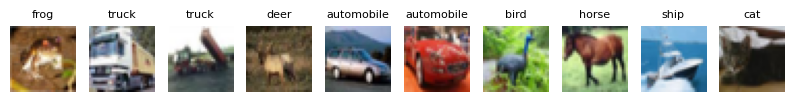

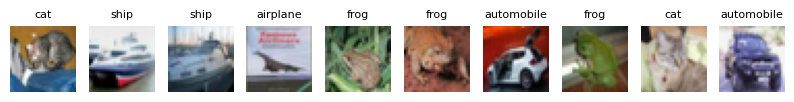

In [3]:
# データ読み込み
(x_train, t_train), (x_test, t_test) = cifar10.load_data()

# データの可視化 cifar10
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

# データの確認
print("x_train.shape:", x_train.shape)
print("x_train.dtype:", x_train.dtype)
print("x_train range", float(x_train.min()), "->", float(x_train.max()))
print("dtype:", x_train.dtype)

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i])
    plt.axis("off")
    plt.title(classes[t_train[i,0]], fontsize=8)
plt.show()

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")
    plt.title(classes[t_test[i,0]], fontsize=8)
plt.show()

In [4]:
# 前処理（float32にキャストして正規化して学習の安定化を図る）
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm  = x_test.astype("float32") / 255.0

# データの確認
print("x_train.shape:", x_train_norm.shape)
print("x_train.dtype:", x_train_norm.dtype)
print("x_train range", float(x_train_norm.min()), "->", float(x_train_norm.max()))
print("dtype:", x_train_norm.dtype)

x_train.shape: (50000, 32, 32, 3)
x_train.dtype: float32
x_train range 0.0 -> 1.0
dtype: float32


t_train to onehot shape: (50000, 1) -> (50000, 10)
t_train to onehot dtype: uint8 -> float64
t_train onehot range 0.0 -> 1.0


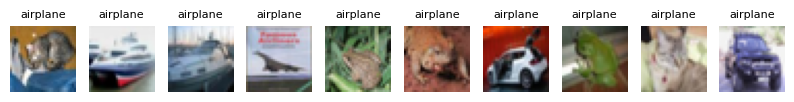

In [76]:
# one-hot convert
n_class = 10
t_train_onehot = keras.utils.to_categorical(t_train, n_class)
t_test_onehot  = keras.utils.to_categorical(t_test, n_class)

# one-hot後のデータの確認
print("t_train to onehot shape:", t_train.shape, "->", t_train_onehot.shape)
print("t_train to onehot dtype:", t_train.dtype, "->", t_train_onehot.dtype)
print("t_train onehot range", float(t_train_onehot.min()), "->", float(t_train_onehot.max()))

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")
    cls_id = int(t_test[i].argmax())
    plt.title(classes[cls_id], fontsize=8)
plt.show()

## モデルの構築
CNNのモデルを構築します。

In [77]:
model = Sequential([
    # TensroFlowの入力引数に画像情報を設定(heig:32,width:32,channel:3)
    # batchサイズは自動とのこと。
    Input(shape=x_train_norm.shape[1:]),

    # 畳込層の設定。
    # (3,3)ピクセル単位で周辺情報を抽出
    # same:出力のサイズを入力と同じに保つ
    Conv2D(32, (3, 3), padding="same"), Activation("relu"),
    Conv2D(32, (3, 3)), Activation("relu"),

    # Poolic層
    # 特徴を圧縮して、重要情報だけを抽出する
    # 2*2の範囲で最大値を取る＝画像サイズが30->15のように圧縮される。
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding="same"), Activation("relu"),
    Conv2D(64, (3, 3)), Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256), Activation("relu"),
    Dropout(0.5),
    Dense(n_class), Activation("softmax"),
])

model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,218 (2.51 MB)

 Trainable params: 658,218 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

### (次の学習で可視化に使用する作業用の関数)

In [78]:
def show_feature_maps(epoch, logs):
    if epoch % 5 == 0 or epoch == 0:  # 5エポックごとに表示
        test_img = x_test_norm[:1]                         # idx=0 固定
        activations = activation_model.predict(test_img, verbose=0)
        first_layer_act = activations[0][0]                # Conv1 の特徴マップ (H, W, C)

        label_id = int(t_test_onehot[0].argmax())          # idx=0 の正解ラベル

        n_show = 4 # 確認用に表示する特徴フィルタの数
        fig, axes = plt.subplots(1, n_show+1, figsize=(8, 2), constrained_layout=True)

        # 比較用に元画像を一番左に追加
        axes[0].imshow(x_test_norm[0])
        axes[0].axis('off')
        axes[0].set_title(f"{classes[label_id]}", fontsize=8)

        for i in range(n_show):
            axes[i+1].imshow(first_layer_act[:, :, i], cmap='viridis') # 0-i番目までのフィルタ特徴画像の出力
            axes[i+1].axis('off')
            axes[i+1].set_title(f"ch {i}", fontsize=8)

        fig.suptitle(f"Epoch {epoch} | idx=0 | label={classes[label_id]}")
        plt.show()

## 学習
モデルを訓練します。  
ImageDataGeneratorを使用する際は、学習にfit_generatorメソッドを使います。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

layer[1] kernels shape: (3, 3, 3, 32)


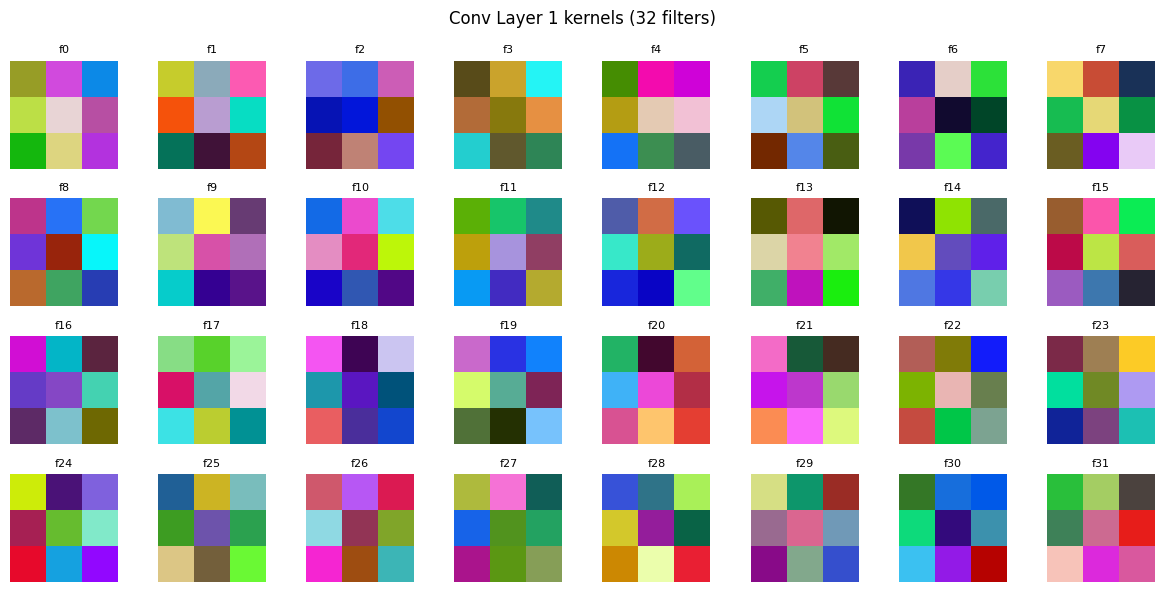

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3499 - loss: 1.7535

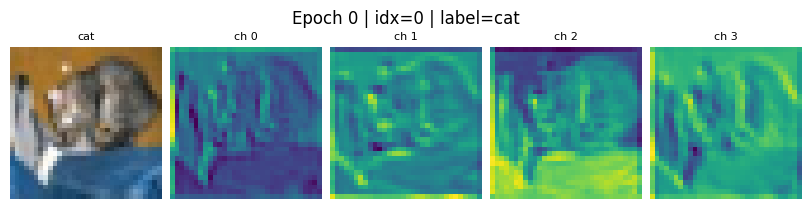

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.3499 - loss: 1.7534 - val_accuracy: 0.6086 - val_loss: 1.1046
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6089 - loss: 1.1184 - val_accuracy: 0.6894 - val_loss: 0.8858
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6886 - loss: 0.8977 - val_accuracy: 0.7263 - val_loss: 0.7817
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7282 - loss: 0.7718 - val_accuracy: 0.7328 - val_loss: 0.7534
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7551 - loss: 0.6957 - val_accuracy: 0.7439 - val_loss: 0.7289
Epoch 6/15
1554/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7843 - loss: 0.6155

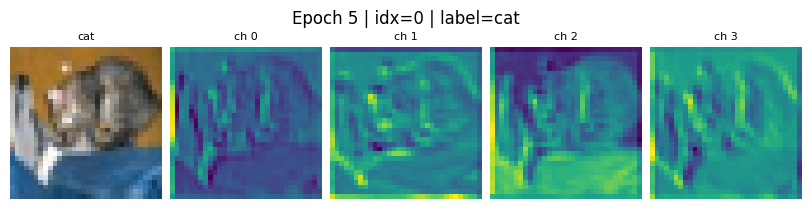

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7843 - loss: 0.6156 - val_accuracy: 0.7203 - val_loss: 0.8223
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7975 - loss: 0.5719 - val_accuracy: 0.7690 - val_loss: 0.7022
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8190 - loss: 0.5162 - val_accuracy: 0.7662 - val_loss: 0.7081
Epoch 9/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8294 - loss: 0.4754 - val_accuracy: 0.7706 - val_loss: 0.7210
Epoch 10/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8418 - loss: 0.4444 - val_accuracy: 0.7556 - val_loss: 0.7805
Epoch 11/15
1552/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8521 - loss: 0.4083

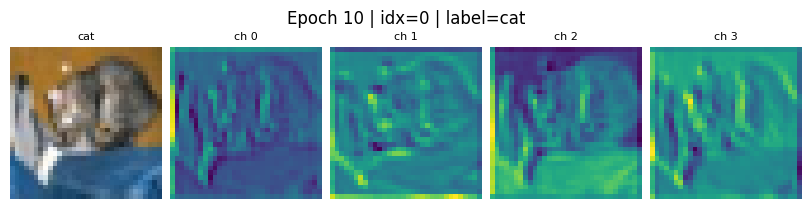

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8521 - loss: 0.4085 - val_accuracy: 0.7644 - val_loss: 0.7645
Epoch 12/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8648 - loss: 0.3800 - val_accuracy: 0.7615 - val_loss: 0.7886
Epoch 13/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8723 - loss: 0.3580 - val_accuracy: 0.7689 - val_loss: 0.7784
Epoch 14/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8799 - loss: 0.3365 - val_accuracy: 0.7564 - val_loss: 0.8554
Epoch 15/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8849 - loss: 0.3278 - val_accuracy: 0.7691 - val_loss: 0.8512


In [79]:
# HP
batch_size = 32
epochs = 15

# === 学習の可視化設定 ===
# convの層の出力を取得
conv_layers = [l for l in model.layers if isinstance(l, Conv2D)]
conv_outputs = [l.output for l in conv_layers]
activation_model = Model(inputs=model.inputs, outputs=conv_outputs)

# Callbackを登録＆Fit関数に渡す
cb_feat = LambdaCallback(on_epoch_end=show_feature_maps)
# ====================

# === 学習 ===
history = model.fit(
    x_train_norm, t_train_onehot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test_norm, t_test_onehot),
    shuffle=True,
    callbacks=[cb_feat]
)

## 学習の推移
学習の推移を表示します。  

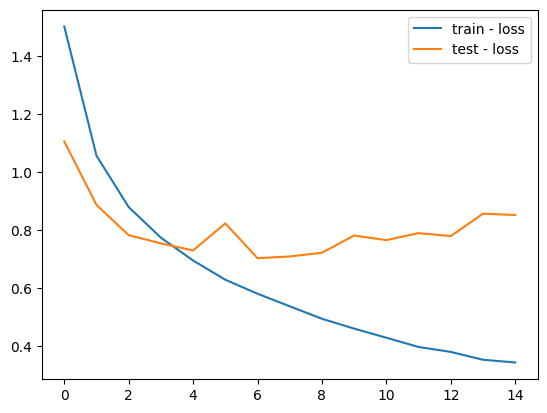

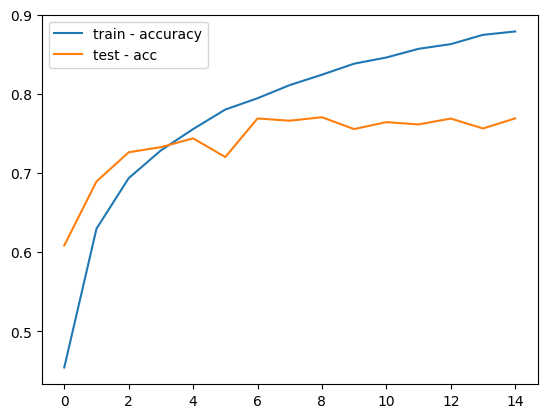

In [82]:
# 学習曲線
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(np.arange(len(train_loss)), train_loss, label="train - loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="test - loss")
plt.legend(); plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label="train - accuracy")
plt.plot(np.arange(len(val_acc)), val_acc, label="test - acc")
plt.legend(); plt.show()

## 評価
モデルの評価を行います。  

In [ ]:
# 評価
loss, accuracy = model.evaluate(x_test_norm, t_test_onehot)
print("loss:", loss, "accuracy:", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7617 - loss: 0.9923


loss: 0.9932031035423279 accuracy: 0.7574999928474426


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## モデルの保存とダウンロード
他の環境でも使えるように、モデルを保存しダウンロードします。

In [ ]:
from google.colab import files

# 保存とダウンロード（.h5 で保存したい場合は h5py が必要）
from google.colab import files
model.save("image_classifier.h5", include_optimizer=False)  # HDF5形式
files.download("image_classifier.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

.h5の拡張子を持つモデルのファイルが、ローカルに保存されました。

# Task
Analyze the provided code to identify potential reasons for the low validation accuracy (0.1) and propose solutions to improve the model's performance.

## モデル構造の確認と改善

### Subtask:
現在の CNN モデルの層の数や種類、活性化関数などがデータセットに適しているか確認します。必要に応じて、層の追加や変更を検討します。


**Reasoning**:
Review the current model architecture using `model.summary()` output and compare it to typical CNN architectures for image classification like CIFAR-10 to identify potential areas for improvement in layer types, counts, and activation functions. Then, consider alternative layer configurations without implementing code changes yet.



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,974,656 (7.53 MB)

 Trainable params: 658,218 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,316,438 (5.02 MB)

## 学習率の調整

### Subtask:
Adam オプティマイザの学習率が適切か確認し、必要に応じて調整します。


**Reasoning**:
Check if the learning rate for the Adam optimizer is explicitly set in the code. If not, assume the default learning rate is being used.



In [ ]:
# The Adam optimizer is compiled without an explicit learning rate.
# This means the default learning rate (usually 0.001) is being used.
# Given the consistently low accuracy, the learning rate might be too high
# or too low, preventing effective learning.

# To address this, we will recompile the model with a potentially different
# learning rate or introduce a learning rate scheduler.

# For this step, let's explicitly set a learning rate to demonstrate the process.
# A smaller learning rate might help the model converge better, especially if
# the current one is causing oscillations or divergence early in training.
# Let's try a smaller learning rate, for example, 0.0001.

# Recompile the model with a new Adam optimizer instance with a different learning rate
new_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=new_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,218 (2.51 MB)

 Trainable params: 658,218 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The model has been recompiled with a smaller learning rate. Now, retrain the model with the new learning rate to see if the performance improves.



Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9231 - loss: 0.2116 - val_accuracy: 0.7754 - val_loss: 1.0399
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9388 - loss: 0.1645 - val_accuracy: 0.7738 - val_loss: 1.0652
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9442 - loss: 0.1495 - val_accuracy: 0.7774 - val_loss: 1.0893
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9488 - loss: 0.1375 - val_accuracy: 0.7796 - val_loss: 1.1357
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9553 - loss: 0.1263 - val_accuracy: 0.7784 - val_loss: 1.1284
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9552 - loss: 0.1185 - val_accuracy: 0.7803 - val_loss: 1.1801
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9600 - loss: 0.1122 - val_accuracy: 0.7796 - val_loss: 1.1839
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9590 - loss: 0.1104 -

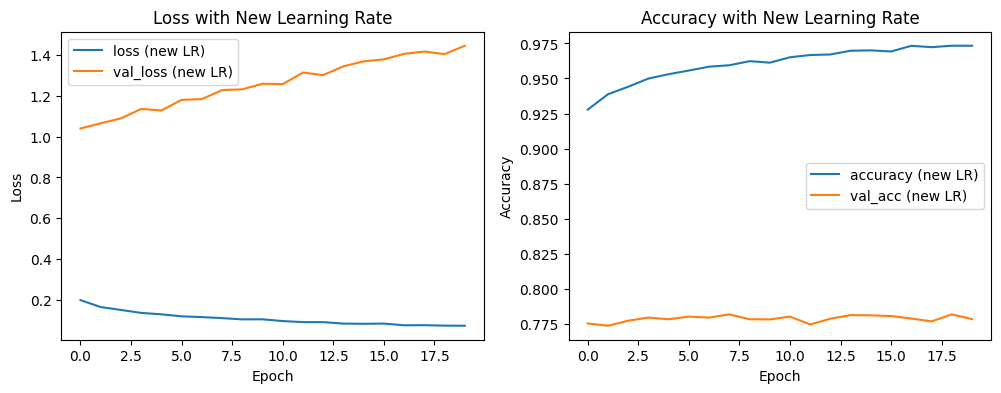

In [ ]:
# Retrain the model with the new learning rate
batch_size = 32
epochs = 20 # Keeping the number of epochs the same for comparison initially
history_new_lr = model.fit(
    x_train, t_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, t_test),
    shuffle=True,
)

# Evaluate the model with the new learning rate
loss_new_lr, accuracy_new_lr = model.evaluate(x_test, t_test, verbose=0)
print(f"loss with new LR: {loss_new_lr}, accuracy with new LR: {accuracy_new_lr}")

# Plot the training history with the new learning rate
train_loss_new_lr = history_new_lr.history["loss"]
val_loss_new_lr = history_new_lr.history["val_loss"]
train_acc_new_lr = history_new_lr.history["accuracy"]
val_acc_new_lr = history_new_lr.history["val_accuracy"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_loss_new_lr)), train_loss_new_lr, label="loss (new LR)")
plt.plot(np.arange(len(val_loss_new_lr)), val_loss_new_lr, label="val_loss (new LR)")
plt.title("Loss with New Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_acc_new_lr)), train_acc_new_lr, label="accuracy (new LR)")
plt.plot(np.arange(len(val_acc_new_lr)), val_acc_new_lr, label="val_acc (new LR)")
plt.title("Accuracy with New Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

**Reasoning**:
The error message `ValueError: Arguments target and output must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 10)` indicates that the target labels `t_train` and `t_test` are not in the correct one-hot encoded format expected by the categorical crossentropy loss function. Looking back at the notebook history, it seems the `to_categorical` conversion was performed earlier, but it's possible the variables were overwritten or not correctly applied. The target shape (None, 1) suggests the labels are still in their original integer format. We need to ensure the target labels are correctly one-hot encoded before training again.



In [ ]:
# The error indicates that the target labels are not in the correct shape
# for categorical_crossentropy. This likely means they are not one-hot encoded.
# We will re-apply the one-hot encoding to ensure the target shapes are correct.

# Re-apply one-hot encoding
n_class = 10 # Ensure n_class is defined
t_train = keras.utils.to_categorical(t_train, n_class)
t_test  = keras.utils.to_categorical(t_test, n_class)

# Now, retry training the model with the new learning rate
batch_size = 32
epochs = 20 # Keeping the number of epochs the same for comparison initially
history_new_lr = model.fit(
    x_train, t_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, t_test),
    shuffle=True,
)

# Evaluate the model with the new learning rate
loss_new_lr, accuracy_new_lr = model.evaluate(x_test, t_test, verbose=0)
print(f"loss with new LR: {loss_new_lr}, accuracy with new LR: {accuracy_new_lr}")

# Plot the training history with the new learning rate
train_loss_new_lr = history_new_lr.history["loss"]
val_loss_new_lr = history_new_lr.history["val_loss"]
train_acc_new_lr = history_new_lr.history["accuracy"]
val_acc_new_lr = history_new_lr.history["val_accuracy"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_loss_new_lr)), train_loss_new_lr, label="loss (new LR)")
plt.plot(np.arange(len(val_loss_new_lr)), val_loss_new_lr, label="val_loss (new LR)")
plt.title("Loss with New Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_acc_new_lr)), train_acc_new_lr, label="accuracy (new LR)")
plt.plot(np.arange(len(val_acc_new_lr)), val_acc_new_lr, label="val_acc (new LR)")
plt.title("Accuracy with New Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

Epoch 1/20


ValueError: Cannot take the length of shape with unknown rank.

**Reasoning**:
The `ValueError: Creating variables on a non-first call to a function decorated with tf.function` error typically occurs when recompiling a Keras model and then trying to fit it again within the same TensorFlow graph context without properly resetting the state or creating a new model instance. Since we already recompiled the model with the new learning rate in a previous step, the issue isn't recompiling itself, but rather the state of the `model` object after recompilation within the interactive notebook environment. The simplest way to resolve this is to redefine and recompile the model from scratch before fitting it with the new learning rate.



In [ ]:
# The error "Creating variables on a non-first call to a function decorated with tf.function"
# suggests an issue with the model state after recompilation.
# To fix this, we will redefine and recompile the model from scratch
# with the desired learning rate before training.

# Redefine the model architecture
model = Sequential([
    Input(shape=x_train.shape[1:]),                         # (32,32,3)
    Conv2D(32, (3, 3), padding="same"), Activation("relu"),
    Conv2D(32, (3, 3)), Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding="same"), Activation("relu"),
    Conv2D(64, (3, 3)), Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256), Activation("relu"),
    Dropout(0.5),
    Dense(n_class), Activation("softmax"),
])

# Recompile the model with the new Adam optimizer instance and learning rate
new_learning_rate = 0.0001 # Use the smaller learning rate
model.compile(optimizer=Adam(learning_rate=new_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

# Now, retry training the model with the new learning rate using the freshly compiled model
batch_size = 32
epochs = 20 # Keeping the number of epochs the same for comparison initially
history_new_lr = model.fit(
    x_train, t_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, t_test),
    shuffle=True,
)

# Evaluate the model with the new learning rate
loss_new_lr, accuracy_new_lr = model.evaluate(x_test, t_test, verbose=0)
print(f"loss with new LR: {loss_new_lr}, accuracy with new LR: {accuracy_new_lr}")

# Plot the training history with the new learning rate
train_loss_new_lr = history_new_lr.history["loss"]
val_loss_new_lr = history_new_lr.history["val_loss"]
train_acc_new_lr = history_new_lr.history["accuracy"]
val_acc_new_lr = history_new_lr.history["val_accuracy"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_loss_new_lr)), train_loss_new_lr, label="loss (new LR)")
plt.plot(np.arange(len(val_loss_new_lr)), val_loss_new_lr, label="val_loss (new LR)")
plt.title("Loss with New Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_acc_new_lr)), train_acc_new_lr, label="accuracy (new LR)")
plt.plot(np.arange(len(val_acc_new_lr)), val_acc_new_lr, label="val_acc (new LR)")
plt.title("Accuracy with New Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()